In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
from datasets import load_dataset
import pandas as pd
from tqdm import tqdm
import string
import nltk
import re
import numpy as np
from transformers import XLMRobertaTokenizer, XLMRobertaModel
from transformers import get_linear_schedule_with_warmup
import torch
from torch import nn, optim
import pickle
from torch.utils.data import Dataset, DataLoader

In [ ]:
numbers = {
    '0': 'zero',
    '1': 'one',
    '2': 'two',
    '3': 'three',
    '4': 'four',
    '5': 'five',
    '6': 'six',
    '7': 'seven',
    '8': 'eight',
    '9': 'nine'
}

def remove_puntuations(txt):
    punct = set(string.punctuation)
    txt = " ".join(txt.split("."))
    txt = " ".join(txt.split("!"))
    txt = " ".join(txt.split("?"))
    txt = " ".join(txt.split(":"))
    txt = " ".join(txt.split(";"))
    txt = " ".join(txt.split('-'))

    txt = "".join(ch for ch in txt if ch not in punct)
    return txt

def number_to_words(txt):
    for k in numbers.keys():
        txt = txt.replace(k,numbers[k]+" ")
    return txt

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'_',' ',text)
    text = number_to_words(text)
    text = remove_puntuations(text)
    text = ''.join([i if ord(i) < 128 else '' for i in text])
    text = ' '.join(text.split())
    return text

In [ ]:
dataset = load_dataset('multi_eurlex', 'all_languages')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for multi_eurlex contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/multi_eurlex
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(

Generating train split:   0%|          | 0/55000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

## Training

In [ ]:
dataset['train']

Dataset({
    features: ['celex_id', 'text', 'labels'],
    num_rows: 55000
})

In [ ]:
train_sentences_en = []
train_labels = []
for i in tqdm(dataset['train']):
    train_sentences_en.append(preprocess_text(i['text']['en']))
    train_labels.append(i['labels'])

val_sentences_en = []
val_labels = []
for i in tqdm(dataset['validation']):
    val_sentences_en.append(preprocess_text(i['text']['en']))
    val_labels.append(i['labels'])

100%|██████████| 5000/5000 [00:15<00:00, 316.01it/s]


In [ ]:
unique_vals = []
for i in train_labels:
    unique_vals.extend(i)
unique_labels = np.unique(unique_vals)

In [ ]:
actual_train_labels = []
for i in tqdm(train_labels):
    labels = []
    for j in unique_labels:
        if j in i:
            labels.append(1)
        else:
            labels.append(0)
    actual_train_labels.append(labels)

actual_val_labels = []
for i in tqdm(val_labels):
    labels = []
    for j in unique_labels:
        if j in i:
            labels.append(1)
        else:
            labels.append(0)
    actual_val_labels.append(labels)

100%|██████████| 5000/5000 [00:00<00:00, 105631.88it/s]


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class MultiLabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }


In [ ]:
class XLMRForMultiLabelClassification(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.xlmr = XLMRobertaModel.from_pretrained('xlm-roberta-base')
        self.classifier = nn.Linear(self.xlmr.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.xlmr(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  # pooler_output in XLM-R is the last hidden state of the first token (CLS token)
        logits = self.classifier(pooled_output)
        return torch.sigmoid(logits)


In [ ]:
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [ ]:
train_ds = MultiLabelDataset(train_sentences_en, actual_train_labels, tokenizer, max_len=128)
val_ds = MultiLabelDataset(val_sentences_en, actual_val_labels, tokenizer, max_len=128)

In [ ]:
train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=64, shuffle=True)

In [ ]:
model = XLMRForMultiLabelClassification(num_labels=21).to(device)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.BCELoss()
num_epochs = 3

train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    total_train_loss = 0
    for batch in tqdm(train_dataloader):
        input_ids, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['labels']
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation step
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            input_ids, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['labels']
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    # Print losses
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

    model.train()  # Set the model back to training mode

100%|██████████| 79/79 [01:27<00:00,  1.11s/it]


Epoch 1, Train Loss: 0.30167291789900424, Val Loss: 0.2623625084569183


100%|██████████| 79/79 [01:27<00:00,  1.10s/it]


Epoch 2, Train Loss: 0.2016931755424932, Val Loss: 0.21574187486232083


100%|██████████| 79/79 [01:26<00:00,  1.09s/it]

Epoch 3, Train Loss: 0.17173548568646574, Val Loss: 0.2005599126031127


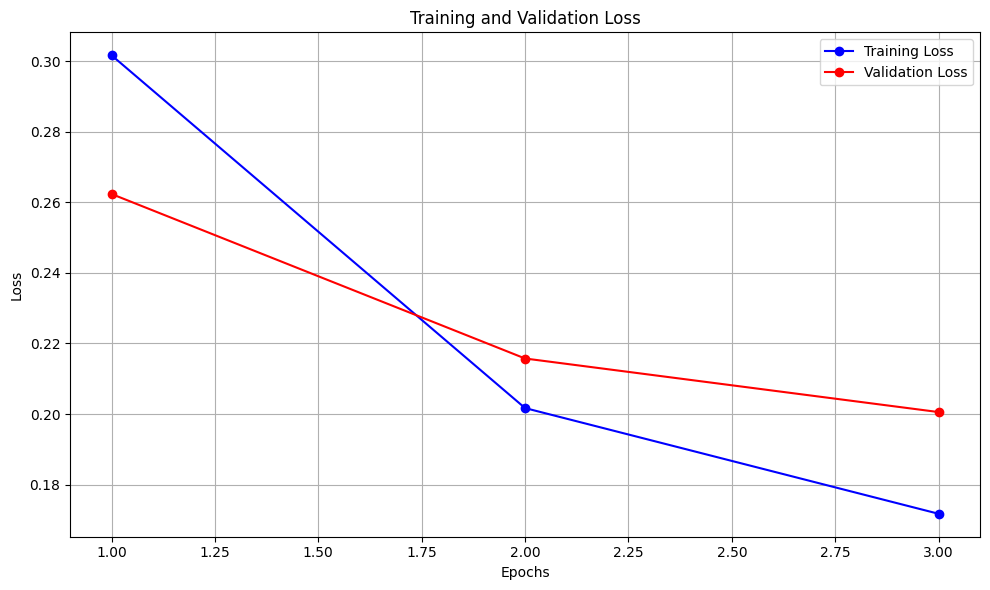

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o', color='red')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/NLP/Project/MT/xlm-roberta-base-model_training_validation_loss_plot.png')  # Save the plot as a PNG file
plt.show()


In [ ]:
torch.save(model, '/content/drive/MyDrive/NLP/Project/MT/xlm-roberta-base-model_2_epochs')

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/NLP/Project/MT/xlm-roberta-base-model_state_dict_2_epochs.pt')

## Preds

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
!pip install easynmt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylin

In [ ]:
from easynmt import EasyNMT
translation_model = EasyNMT('opus-mt')

In [ ]:
classification_model = XLMRForMultiLabelClassification(num_labels=21).to(device)
classification_model.load_state_dict(torch.load('/content/drive/MyDrive/NLP/Project/MT/xlm-roberta-base-model_state_dict_2_epochs.pt', map_location=torch.device(device)))

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:
def predict(model, tokenizer, text, max_len=128):
    model.eval()
    # Tokenize the text
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        return_tensors='pt',  # Return PyTorch tensors
        padding='max_length',
        truncation=True
    )

    # Extract inputs
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Get predictions
    with torch.no_grad():  # Disable gradient calculation for inference
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Convert outputs to probabilities
    probabilities = outputs.squeeze().detach().cpu().numpy()
    return probabilities


In [ ]:
# def get_preds_for_language(lang, pred_labels, true_labels):
#     sentences = []
#     # predicted_labels = []
#     # true_labels = []

#     for i in tqdm(dataset['test'].select(range(3000, 4000))):
#         try:
#             sentence = i['text'][lang]
#             labels = i['labels']

#             sentences.append(sentence)
#             true_labels_ohe = [0]*21
#             for i in labels:
#                 true_labels_ohe[i] = 1
#             true_labels.append(true_labels_ohe)
#         except:
#             continue

#     print("Sentences compiled")
#     print("Translating...")

#     translated_sentences = translation_model.translate(sentences, target_lang = 'en')

#     for sentence in translated_sentences:
#         predictions = predict(classification_model, tokenizer, preprocess_text(sentence))
#         preds_new = [1 if i > np.average(predictions) else 0 for i in predictions]

#         pred_labels.append(preds_new)
#     return pred_labels, true_labels

In [ ]:
def get_preds_for_language(lang, pred_labels, true_labels):
    sentences = []
    # predicted_labels = []
    # true_labels = []

    for i in tqdm(dataset['test'].select(range(2000, 2500))):
        try:
            sentence = i['text'][lang]
            labels = i['labels']

            translated_sentence = translation_model.translate(preprocess_text(sentence), target_lang = 'en')

            predictions = predict(classification_model, tokenizer, preprocess_text(translated_sentence))
            preds_new = [1 if i > np.average(predictions) else 0 for i in predictions]
            pred_labels.append(preds_new)

            true_labels_ohe = [0]*21
            for i in labels:
                true_labels_ohe[i] = 1
            true_labels.append(true_labels_ohe)
        except Exception as e:
            continue
    return pred_labels, true_labels

In [ ]:
lang = 'es'
# pred_labels, true_labels = [], []

pred_labels = pickle.load(open(f'/content/drive/MyDrive/NLP/Project/MT/Labels/pred_labels_{lang}.pkl', 'rb'))
true_labels = pickle.load(open(f'/content/drive/MyDrive/NLP/Project/MT/Labels/true_labels_{lang}.pkl', 'rb'))

In [ ]:
import warnings
warnings.filterwarnings('ignore')
pred_labels, true_labels = get_preds_for_language(lang, pred_labels, true_labels)
pickle.dump(pred_labels, open(f'/content/drive/MyDrive/NLP/Project/MT/Labels/pred_labels_{lang}.pkl', 'wb'))
pickle.dump(true_labels, open(f'/content/drive/MyDrive/NLP/Project/MT/Labels/true_labels_{lang}.pkl', 'wb'))

 36%|███▋      | 182/500 [11:28<20:31,  3.87s/it]

In [ ]:
len(pred_labels)

1999

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
pred_labels_flattened = np.array(pred_labels).flatten()
true_labels_flattened = np.array(true_labels).flatten()
print(f"Accuracy: {accuracy_score(pred_labels_flattened, true_labels_flattened)}")
print(classification_report(pred_labels_flattened, true_labels_flattened))

Accuracy: 0.8033161806746713
              precision    recall  f1-score   support

           0       0.84      0.91      0.88     28030
           1       0.62      0.45      0.52      8699

    accuracy                           0.80     36729
   macro avg       0.73      0.68      0.70     36729
weighted avg       0.79      0.80      0.79     36729



## RANDOM

In [ ]:
dataset['test'][0]['text'].keys()

dict_keys(['bg', 'cs', 'da', 'de', 'el', 'en', 'es', 'et', 'fi', 'fr', 'hr', 'hu', 'it', 'lt', 'lv', 'mt', 'nl', 'pl', 'pt', 'ro', 'sk', 'sl', 'sv'])

In [ ]:
sentence = dataset['test'][0]['text']['lv']
# # print(sentence)
# # print()
print(dataset['test'][9]['text']['en'])
en_text = translation_model.translate(sentence, target_lang='en')
print(en_text)
# # probabilities = predict(classification_model, tokenizer, preprocess_text(en_text))

In [ ]:
probabilities_new = [1 if i > np.average(probabilities) else 0 for i in probabilities]
probabilities_new

[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [ ]:
[i for i in range(len(probabilities_new)) if probabilities_new[i] == 1]

[3, 6, 17]

In [ ]:
dataset['test'][9]['labels']

[3, 17, 15, 6]